In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy.polynomial import legendre
from astropy.io import fits
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture as ca
from photutils.aperture import EllipticalAperture as ea
from astropy.coordinates import Angle as ang
from photutils.detection import DAOStarFinder as DAO
from astropy.stats import sigma_clipped_stats as scs

In [2]:
def read_data_file(filename):
    data = np.loadtxt(filename, delimiter=',')
    x_in = data[:, 0]
    y_in = data[:, 1]
    x_out = data[:, 2]
    y_out = data[:, 3]
    return x_in, y_in, x_out, y_out

In [3]:
def custom_legendre(x_coeffs, y_coeffs, x, y, order):
    import numpy as np
    from numpy.polynomial import legendre
    x_terms = legendre.legval2d(x, y, x_coeffs)
    y_terms = legendre.legval2d(x, y, y_coeffs)
    return np.array(x_terms), np.array(y_terms)

In [4]:
def residual(coeffs, x_in, y_in, x_out, y_out, order):
    coeffs = coeffs.reshape(2, order, order)

    x_coeffs = coeffs[0, :, :]
    y_coeffs = coeffs[1, :, :]
    fitted_x_terms, fitted_y_terms = custom_legendre(x_coeffs, y_coeffs, x_in, y_in, order)
    residuals = np.concatenate((fitted_x_terms - x_out, fitted_y_terms - y_out))
    return residuals

In [5]:
input_filename = '2023cj.in'
output_filename = '2023cj.out'

# Read input data
x_in, y_in, x_out, y_out = read_data_file(input_filename)

# Parameters
order = 3
max_iters = 10
outlier_threshold = 3.0

for iteration in range(max_iters):
    # Perform outlier rejection using least squares optimization
    initial_coeffs = np.ones(2 * order * order) # Coefficients for both x and y terms
    result = least_squares(residual, initial_coeffs, args=(x_in, y_in, x_out, y_out, order))
    final_coeffs = result.x
    final_coeffs = final_coeffs.reshape(2, order, order)

    final_x_coeffs = final_coeffs[0, :, :]
    final_y_coeffs = final_coeffs[1, :, :]

    
    # Calculate residuals using the final coefficients and fitted values
    fitted_x, fitted_y = custom_legendre(final_x_coeffs, final_y_coeffs, x_in, y_in, order)
    residuals_x = fitted_x - x_out
    residuals_y = fitted_y - y_out

    # Calculate RMS of the transformation
    combined_residuals = np.sqrt(residuals_x**2 + residuals_y**2)
    rms = np.sqrt(np.mean(combined_residuals ** 2))

    # Count and display number of outliers removed
    num_outliers_removed = np.sum(combined_residuals >= outlier_threshold * rms)

    # Print iteration details
    print(f"Iteration {iteration+1}")
    print(f"RMS of the transformation: {rms}")
    print("Number of outliers removed:", num_outliers_removed)
    print("Coefficients:", final_coeffs)

    # Break the loop if no outliers were removed
    if num_outliers_removed == 0:
        break

    # Update the data for the next iteration
    x_in = x_in[combined_residuals < outlier_threshold * rms]
    y_in = y_in[combined_residuals < outlier_threshold * rms]
    x_out = x_out[combined_residuals < outlier_threshold * rms]
    y_out = y_out[combined_residuals < outlier_threshold * rms]

Iteration 1
RMS of the transformation: 2.390815208716261
Number of outliers removed: 2
Coefficients: [[[ 1.70629174e+03 -3.41486219e-01 -1.54711695e-05]
  [-8.80904434e-01 -9.22682365e-05  3.52923605e-08]
  [-1.17626291e-05  3.27223148e-08 -1.25536023e-11]]

 [[ 1.15238232e+03 -9.30788604e-01  8.63054583e-06]
  [ 3.70383996e-01  4.65359588e-05 -2.38298346e-08]
  [ 5.31705771e-06 -1.92177807e-08  9.49009866e-12]]]
Iteration 2
RMS of the transformation: 0.6640118688349077
Number of outliers removed: 5
Coefficients: [[[ 1.72001250e+03 -3.82191153e-01  5.83542551e-07]
  [-9.10890126e-01 -3.10274676e-06 -1.44684916e-10]
  [-1.06118763e-06  1.37193828e-09 -7.72059984e-14]]

 [[ 1.14202750e+03 -9.01714693e-01 -3.95057764e-06]
  [ 3.96688543e-01 -3.07210410e-05  1.04499230e-08]
  [-5.14322274e-06  1.12941060e-08 -3.96988628e-12]]]
Iteration 3
RMS of the transformation: 0.42070336002841796
Number of outliers removed: 7
Coefficients: [[[ 1.72140002e+03 -3.85881369e-01  2.08562261e-06]
  [-9.1541

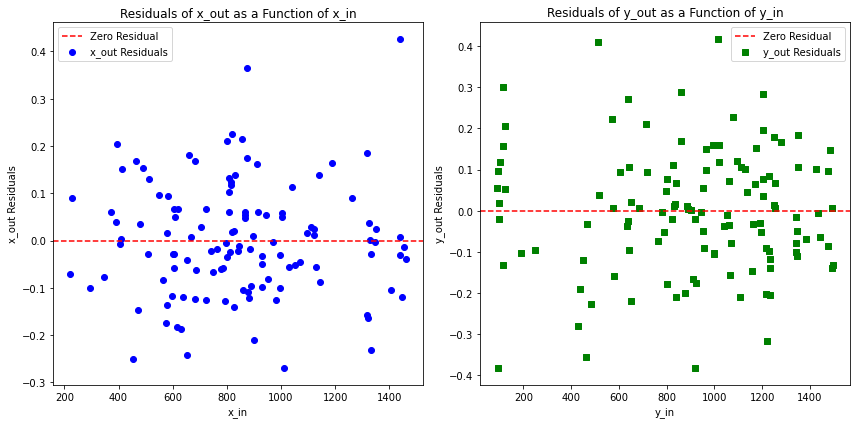

In [6]:
# Plot residuals as functions of x_in and y_in
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x_in, residuals_x, c='b', marker='o', label='x_out Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.xlabel('x_in')
plt.ylabel('x_out Residuals')
plt.title('Residuals of x_out as a Function of x_in')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_in, residuals_y, c='g', marker='s', label='y_out Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.xlabel('y_in')
plt.ylabel('y_out Residuals')
plt.title('Residuals of y_out as a Function of y_in')
plt.legend()
plt.savefig('residuals_x-out_y-out.png', dpi = 500, format = 'png')

plt.tight_layout()
plt.show()

In [7]:
for i in range(len(x_in)):
    print(x_in[i], y_in[i], residuals_x[i], residuals_y[i])

969.697 88.67 -0.0039979595222803255 0.05471869775806226
997.513 93.453 -0.10081911209476857 0.09562343047468858
874.177 95.46 0.3648669831910638 -0.3818504175308135
866.045 97.731 0.053951441343087936 -0.019801398987283392
879.37 98.983 -0.10939415510370054 0.019022911182219104
1053.055 101.256 -0.05153301446773639 0.1180365180937315
1009.741 113.684 -0.2703029422769987 -0.13192144779145565
1002.406 114.787 0.059358450505442306 0.1572137509986078
829.075 115.701 0.13913204954667435 0.30135520872204324
784.506 121.91 -0.05833154005324559 0.05276090963798197
854.258 122.78 0.21578573470958418 0.20656238249989656
929.216 190.384 -0.03300530416993297 -0.10265016338280475
763.473 249.899 -0.01694033841374676 -0.0951921345563278
814.425 426.538 0.12447791674946984 -0.278934838713667
827.763 435.41 -0.13959576184606703 -0.1896702296278363
981.52 447.865 -0.1250690205894216 -0.11997186654275538
799.618 461.259 -0.035096624230277484 -0.3562248791554339
792.641 464.223 -0.1267384685476145 -0.03

In [8]:
print(len(x_in))
print(rms)

121
0.1922433159432408


In [9]:
# Write retained points to a file
data = np.column_stack((x_in, y_in, x_out, y_out))  # Stack input and output coordinates
np.savetxt(output_filename, data, delimiter=',', header="x_in,y_in,x_out,y_out", comments='')

In [10]:
#SN in = 813.68102 789.18635
#SN out = 719.3415020310174 778.6999148972727
sn_pos = [751.134,750.004]
sn_out = custom_legendre(final_x_coeffs, final_y_coeffs, sn_pos[0], sn_pos[1], order)
print(sn_out)

(array(747.69491088), array(749.67102569))


In [11]:
# SN Pos in ra/dec
# RA: 14:06:32.5593
# Dec: -5:27:06.268

In [12]:
pre_x, pre_y = 747.69491088, 749.67102569
pre_ex = fits.open('wfc3.f350lp.ref_0001.drz_cropped.fits')
pre_data = pre_ex[0]
img1 = pre_data.data
mean, median, std = scs(img1)

In [13]:
# Getting the Positions of the sources found earlier for this

pre_sources_astro= np.loadtxt('2023cj_pre_sources_matched.dat', usecols = (0, 1), ndmin= 2)

# daopre = DAO(fwhm = 3.0, threshold = 5.0 * std, xycoords = pre_sources_astro)
daopre = DAO(fwhm = 3.0, threshold = 5.0 * std)
sources = daopre(img1-median)

for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'
        
sources.pprint(max_width = 76)

 id xcentroid ycentroid sharpness roundness1 ... sky     peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- --------- ---- -----
  1     40.11      3.30      0.57       0.02 ... 0.00 111460.93 9.94 -2.49
  2    949.94      7.25      0.57       0.01 ... 0.00  13552.51 1.16 -0.16
  3    744.02      9.01      0.61      -0.14 ... 0.00  33247.41 2.83 -1.13
  4    940.15     12.06      0.60       0.25 ... 0.00  13861.39 1.04 -0.04
  5   1027.31     12.48      0.60       0.13 ... 0.00  11634.48 1.09 -0.09
  6    689.79     13.58      0.55       0.19 ... 0.00  13093.08 1.01 -0.01
  7   1011.97     16.69      0.52      -0.41 ... 0.00  19297.15 1.40 -0.37
  8    562.03     36.72      0.44       0.15 ... 0.00  18768.99 1.29 -0.28
  9    918.71     52.02      0.58      -0.54 ... 0.00  12874.89 1.14 -0.14
 10    531.06     62.14      0.58      -0.28 ... 0.00  25452.36 2.27 -0.89
...       ...       ...       ...        ... ...  ...       ...  ...   ...
468    877.52   1397.71  

(720.0, 780.0)

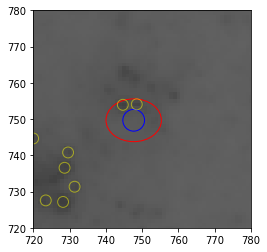

In [14]:
# Plotting the Position + Any Sources nearby

pos1 = np.transpose((sn_out))
aps1 = ca(pos1, r = 3.0)

pos_max = np.transpose((sources['xcentroid'], sources['ycentroid']))
positions = ca(pos_max, r = 1.5)
# Attempting to create an error ellipse using residuals_x, residuals_y values
# Creating a covariance matrix with eigenvalues/vectors (for the semimaj/minor axes;got no idea what im doing :3)

cov = np.cov(residuals_x, residuals_y)
eig, vec = np.linalg.eig(cov)
eig_true = np.sqrt(eig)
angle = ang(0, 'deg')
aps2 = ea(pos1,eig_true[1]*50,eig_true[0]*50, theta = angle)

#Plotting Circular Radius + Error Ellipse + Any Nearby sources
plt.imshow(img1, cmap = 'Greys', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')

aps1.plot(color = 'blue', lw = 1.0, alpha = 1.0)
aps2.plot(color = 'red', lw = 1.0, alpha = 1.0)
positions.plot(color = 'yellow', lw =1.0, alpha = 0.5)

plt.xlim(720,780)
plt.ylim(720,780)
#plt.savefig('wfc3.f350lp.ref_0001.drz_cropped_sn_source.png', dpi = 500, format = 'png')
